In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
from pathlib import Path
import anndata as ad
import scanpy as sc
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
from matplotlib import pyplot as plt

sys.path.insert(0, "/home/ylu/project")
from utils import *
import time

from tqdm import tqdm
%load_ext autoreload
%autoreload 2

/home/ylu/anaconda3/envs/SPACEL/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import SPACEL
from SPACEL import Scube, Splane

In [3]:
subsample_num = 20000
# Load data
data_folder = "../../data/BARseq/BARseq_Perturbed/"
results_folder = "./results/SPACEL/"
Path(results_folder).mkdir(parents=True, exist_ok=True)
cache_folder = os.path.join(results_folder, 'Scube_outputs')
Path(cache_folder).mkdir(parents=True, exist_ok=True)

In [20]:
i = 10
slice1 = ad.read_h5ad(filename=os.path.join(data_folder,"slice_{:0>2d}.h5ad".format(i)))
slice2 = ad.read_h5ad(filename=os.path.join(data_folder,"slice_{:0>2d}.h5ad".format(i+1)))
# subsample
subsample1 = np.random.choice(slice1.shape[0], subsample_num, replace=False) if slice1.shape[0] > subsample_num else np.arange(slice1.shape[0])
subsample2 = np.random.choice(slice2.shape[0], subsample_num, replace=False) if slice2.shape[0] > subsample_num else np.arange(slice2.shape[0])
slice1 = slice1[subsample1,:]
slice2 = slice2[subsample2,:]

In [21]:
slice1

View of AnnData object with n_obs × n_vars = 20000 × 114
    obs: 'cluster', 'slice_id', 'simplify_cluster'
    obsm: 'align_spatial', 'perturbed_spatial', 'spatial', 'spatial_CCF', 'spatial_raw'

In [22]:
slice1.obsm['spatial'] = slice1.obsm['perturbed_spatial'].copy()
slice2.obsm['spatial'] = slice2.obsm['perturbed_spatial'].copy()
align_slices = [slice1, slice2]
anno_key = 'simplify_cluster'
key_added = 'align_spatial'
# align slices
Scube.align(
    align_slices,
    cluster_key=anno_key, 
    n_neighbors = 15, 
    n_threads=10,
    p=2,
    write_loc_path=os.path.join(results_folder, 'Scube_outputs/aligned_coordinates.csv')
)
align_slices[0].obsm[key_added] = align_slices[0].obsm['spatial_aligned'].values
align_slices[1].obsm[key_added] = align_slices[1].obsm['spatial_aligned'].values

Start alignment...
Alignment slice 1 to 0
Runtime: 188.07718873023987 s


In [25]:
R1, t1=solve_RT_by_correspondence(align_slices[1].obsm[key_added], align_slices[1].obsm['perturbed_spatial'])
R2, t2=solve_RT_by_correspondence(align_slices[0].obsm['perturbed_spatial'], align_slices[0].obsm[key_added])
t = t1 @ R2.T + t2
R = R2 @ R1

In [26]:
align_slices[0].obsm[key_added] = align_slices[0].obsm['perturbed_spatial']
align_slices[1].obsm[key_added] = align_slices[1].obsm['perturbed_spatial'] @ R.T + t

In [23]:
key_added = 'align_spatial'
align_slices[0].obsm[key_added] = align_slices[0].obsm['spatial_aligned'].values
align_slices[1].obsm[key_added] = align_slices[1].obsm['spatial_aligned'].values

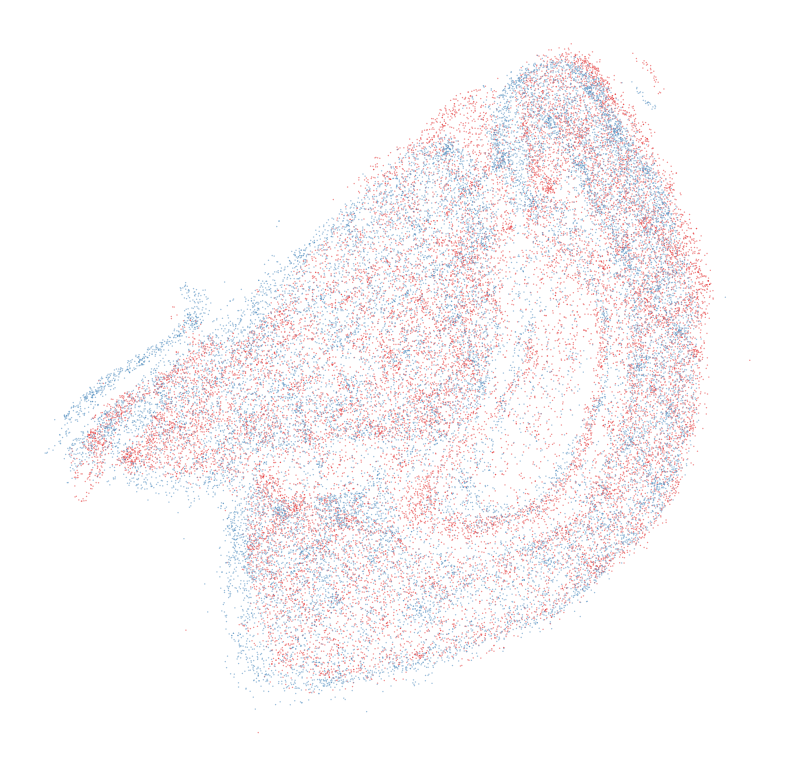

In [27]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_overlay(
    align_slices, 
    key_added,
    ax,
    point_size=1,
    label_key=None,
    palette = "Set1",
    title = '',
    legend=False,
    fontsize=8,
)
plt.show()

In [4]:
subsample_num = 20000
  
for i in tqdm(range(33, 40)):
    slice1 = ad.read_h5ad(filename=os.path.join(data_folder,"slice_{:0>2d}.h5ad".format(i)))
    slice2 = ad.read_h5ad(filename=os.path.join(data_folder,"slice_{:0>2d}.h5ad".format(i+1)))
    
    # subsample
    subsample1 = np.random.choice(slice1.shape[0], subsample_num, replace=False) if slice1.shape[0] > subsample_num else np.arange(slice1.shape[0])
    subsample2 = np.random.choice(slice2.shape[0], subsample_num, replace=False) if slice2.shape[0] > subsample_num else np.arange(slice2.shape[0])
    slice1 = slice1[subsample1,:]
    slice2 = slice2[subsample2,:]
    
    slice1.obsm['spatial'] = slice1.obsm['perturbed_spatial'].copy()
    slice2.obsm['spatial'] = slice2.obsm['perturbed_spatial'].copy()
    align_slices = [slice1, slice2]
    anno_key = 'simplify_cluster'
    key_added = 'align_spatial'
    # align slices
    Scube.align(
        align_slices,
        cluster_key=anno_key, 
        n_neighbors = 15, 
        n_threads=10,
        p=2,
        write_loc_path=os.path.join(results_folder, 'Scube_outputs/aligned_coordinates.csv')
    )
    align_slices[0].obsm[key_added] = align_slices[0].obsm['spatial_aligned'].values
    align_slices[1].obsm[key_added] = align_slices[1].obsm['spatial_aligned'].values

    
    
    # recover true R and t
    R1, t1=solve_RT_by_correspondence(align_slices[1].obsm[key_added], align_slices[1].obsm['perturbed_spatial'])
    R2, t2=solve_RT_by_correspondence(align_slices[0].obsm['perturbed_spatial'], align_slices[0].obsm[key_added])
    t = t1 @ R2.T + t2
    R = R2 @ R1
    results = {"R":R, "t":t, "subsample": [subsample1, subsample2]}
    np.save(os.path.join(results_folder, "slice_{}_{}.npy".format(i,i+1)), results, allow_pickle=True)

  0%|                                                                                                                                                                                                                                  | 0/7 [00:00<?, ?it/s]

Start alignment...
Alignment slice 1 to 0
Runtime: 193.45062947273254 s


 14%|███████████████████████████████                                                                                                                                                                                          | 1/7 [03:14<19:24, 194.06s/it]

Start alignment...
Alignment slice 1 to 0
Runtime: 161.3572220802307 s


 29%|██████████████████████████████████████████████████████████████                                                                                                                                                           | 2/7 [05:55<14:35, 175.15s/it]

Start alignment...
Alignment slice 1 to 0
Runtime: 163.6620283126831 s


 43%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 3/7 [08:40<11:20, 170.16s/it]

Start alignment...
Alignment slice 1 to 0
Runtime: 165.77236795425415 s


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 4/7 [11:26<08:25, 168.63s/it]

Start alignment...
Alignment slice 1 to 0
Runtime: 171.5720157623291 s


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 5/7 [14:18<05:39, 169.90s/it]

Start alignment...
Alignment slice 1 to 0
Runtime: 164.12529349327087 s


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 6/7 [17:03<02:48, 168.12s/it]

Start alignment...
Alignment slice 1 to 0
Runtime: 131.45467877388 s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [19:15<00:00, 165.02s/it]
